https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/

- cloudword plot of keywords in general
- cloudword plot of keywords in negative and positive reviews
- overtime sentiment
- overtime ratings

# **Sentiment Analysis**

**What is sentiment analysis?** 

In simple words, Sentiment analysis is defined as the process of mining of data, view, review or sentence to predict the emotion of the sentence through natural language processing (NLP). The sentiment analysis involve classification of text into three phase “Positive”, “Negative” or“Neutral”. It analyzes the data and labels the ‘better’ and ‘worse’ sentiment as positive and negative respectively.

---

In this analysis different approaches were used:
- a traditional approach using the powerful NLTK (Natural Language ToolKit - https://www.nltk.org/)
- some Machine Learning models (KNN, Naive Bayes, Logistic Regression, SVM,) along with pre-trained Deep Learning models (such as HuggingFace's RoBERTa)
- extra: use of pipelines for making sentiment analysis really quick and easy (this will be really useful for the streamlit sentiment analyzer webapp)

## Importing dependencies

In [793]:
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import json
import nltk

In [794]:
pd.set_option("max_colwidth", None)
plt.style.use('ggplot')

## Data cleaning

After the data scraping/mining step i ended up with a json file which needs to be converted into a pandas dataframe to simplify the analysis. 

This is the purpose of the **json_2_pandas** function: it takes as input the path where the json file is located, than opens it in 'read' ('r') mode to load the data. After loading the data, I iterate through the object to extract review titles, ratings and contents and adding them to a dictionary.

In [795]:
def format_date(css_date):
    date = css_date.split()[len(css_date.split())-3:]
    date_string = " ".join(date)
    date_object = datetime.strptime(date_string, '%d %B %Y')
    formatted_date = date_object.strftime('%Y-%m-%d')
    return formatted_date

In [796]:
def json_2_pandas(json_path):
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)
    
    reviews = {"Date": [],
               "Title": [],
               "Rating": [],
               "Content": []}

    for page in data:
        if len(page) != 0:          # if there are reviews in that page list
            for review in page:
                # append to the lists in the dictionary the desired elements
                reviews['Date'].append(format_date(review['place and date']))
                reviews['Title'].append(review["title"])
                reviews['Rating'].append(int(review["rating"][:1]))
                reviews['Content'].append(review["body"])
    
    reviews = pd.DataFrame.from_dict(reviews)
    return reviews

Converting the .json file into a pandas DataFrame.

In [797]:
path = 'G:\Il mio Drive\MAGISTRALE\IT Coding\Project\Sentiment-Analysis-on-Amazon-product-reviews\Data\B075QVMBT9_reviews.json'
df = json_2_pandas(json_path = path)

In [798]:
# to have all the reviews in a .csv file
df.to_csv('../Data/reviews.csv')
# data = pd.read_csv('../Data/reviews.csv')
# data.head()

In [799]:
df.shape

(740, 4)

In [800]:
df.head(10)

,Date,Title,Rating,Content
0,2023-05-28,Good sound,5,Seem decent build quality and good sound. Very happy with purchase.
1,2023-05-27,I didn't realise how bad my audio setup was,5,"Considering I used to have quite a respectable setup many years ago I've feel into a trap of using Bluetooth speakers which leave a lot to be desired. For the price these provide a perfect audio experience. Now I'm only filling a 3x3m room so hardly an auditorium but the quality is amazing. I do feel like I could do with a subwoofer for some genres but for the average listening experience, without the neighbours complaining, it's beautiful. Almost brings a tear to my eye."
2,2023-05-26,Its a beuaty,5,Love its compact shape and sound
3,2023-05-23,Perfect upgrade for PC Audio,5,"If you ruining cheap PC Speakers those will blow your mind. Clean sound, small frame, good value for money."
4,2023-05-21,Wonderful monitors,5,"It's been some years since using any monitors as I use DT770 250's for all my audio work and wow, I'm so pleased I added these to my studio...First the sound...The sound is quite flat which is good as you can accurately EQ your sound. The bass is ""even"", meaning that it's there but it's not exaggerated. The mids are very well balanced (they sound great) and the high end is also fairly well balanced and you can get some nice air and snap when EQing. For those that have the Bayer Dynamic DT770 250"
5,2023-05-20,Not loud enough,2,These are probably suited for bedroom use and not anything more. The bass kept cutting out with the highs and mids at times also doing the same. Not great at all - I opted for KrK’s instead!
6,2023-05-18,Faulty,1,Passive speaker won't connect to the main speaker.. Faulty.Very disappointed
7,2023-05-17,Brilliant monitor speakers for DJ'ing,5,"Absolutely love these speakers - perfect for DJ'ing at home and loud enough for a little boogie with the kids. Sound quality is great and I'm glad I did my research ahead of time. Build quality is really good, the volume pot is nice and smooth...These would be great for home music production or for gaming...Well worth the investment."
8,2023-05-14,very good but not as good as the harman kardon soundticks,4,very good but not as good as the harman kardon soundticks..though these are smaller overall
9,2023-05-12,Crackling sound when connected to bluetooth,1,"I’d like to preface this review by saying I tried 2 different sets of these speakers (both the bluetooth version), brand new, and both had the EXACT same issue, so must be a model issue rather than a one-off problem...The first pair I bought had a constant crackling/buzzing noise coming from the passive speaker when connected to bluetooth. The noise disappeared when disconnected from bluetooth, but appeared instantly when connected. It was audible at low volumes which ruined the listening experi"


In [801]:
df['Date'] = pd.to_datetime(df['Date'])
df['Id'] = range(len(df))
df.dtypes

Date       datetime64[ns]
Title              object
Rating              int64
Content            object
Id                  int64
dtype: object

Finally we end up with the pandas DataFrame with 738 reviews, all with title, rating and comment. 

In [802]:
print(df.iloc[0]['Title'])

Good sound


In [803]:
print(df.iloc[7]['Content'])

Absolutely love these speakers - perfect for DJ'ing at home and loud enough for a little boogie with the kids. Sound quality is great and I'm glad I did my research ahead of time. Build quality is really good, the volume pot is nice and smooth...These would be great for home music production or for gaming...Well worth the investment.


As we can see from the first review title, there some typing errors which can obviously occur when writing a review. Other than that, it looks like that the punctuation and the backslashes were read properly.

But there could be some missing comments: let's check.

In [804]:
df[df['Content'].str.len() == 0]

,Date,Title,Rating,Content,Id
12,2023-05-07,Great deal.,5,,12
53,2023-03-04,Impressive,5,,53
78,2022-12-29,"Loud, and very clear audio",5,,78
167,2022-06-24,Awesome! General balanced sound!,5,,167
291,2021-10-29,great job presonus,5,,291
296,2021-10-17,Amazing,5,,296
387,2021-04-12,The best speakers I have ever owned,5,,387
563,2020-05-07,Amazing Sound. Best I have ever heard,5,,563
601,2020-02-14,Good quality,3,,601


We have some missing review contents, but thanks to the title and the rating (as we can see) we can draw some sentiment insights either way!

In [805]:
df[df['Rating'] == ""], df[df['Title'] == ""], df[df['Date'] == ""]

(Empty DataFrame
 Columns: [Date, Title, Rating, Content, Id]
 Index: [],
 Empty DataFrame
 Columns: [Date, Title, Rating, Content, Id]
 Index: [],
 Empty DataFrame
 Columns: [Date, Title, Rating, Content, Id]
 Index: [])

Looks like we have 0 missing values for all the columns.

## Exploratory Data Analysis

In [806]:
df['Rating'].describe()

count    740.000000
mean       4.481081
std        1.100335
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64

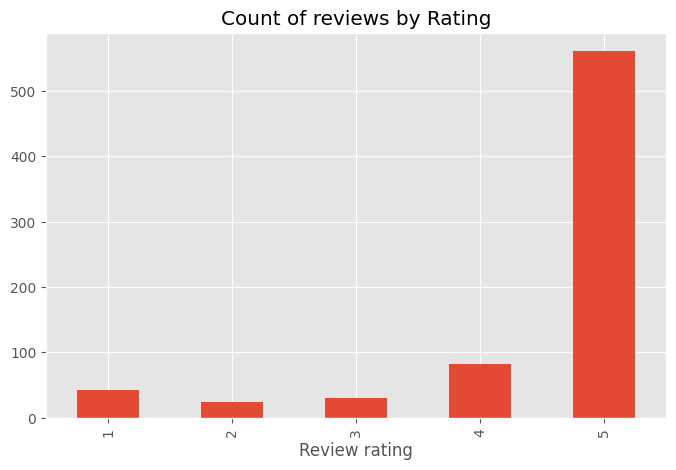

In [807]:
ax = df['Rating'].value_counts().sort_index().plot(kind='bar', title='Count of reviews by Rating', figsize=(8,5))
ax.set_xlabel('Review rating')
plt.show()

Very biased towards positive reviews. That's good to know.

#### NLTK

In [808]:
import nltk
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

In [809]:
example = df['Content'][4]
print(example)

It's been some years since using any monitors as I use DT770 250's for all my audio work and wow, I'm so pleased I added these to my studio...First the sound...The sound is quite flat which is good as you can accurately EQ your sound. The bass is "even", meaning that it's there but it's not exaggerated. The mids are very well balanced (they sound great) and the high end is also fairly well balanced and you can get some nice air and snap when EQing. For those that have the Bayer Dynamic DT770 250


In [810]:
tokens = nltk.word_tokenize(example)
tokens

['It',
 "'s",
 'been',
 'some',
 'years',
 'since',
 'using',
 'any',
 'monitors',
 'as',
 'I',
 'use',
 'DT770',
 '250',
 "'s",
 'for',
 'all',
 'my',
 'audio',
 'work',
 'and',
 'wow',
 ',',
 'I',
 "'m",
 'so',
 'pleased',
 'I',
 'added',
 'these',
 'to',
 'my',
 'studio',
 '...',
 'First',
 'the',
 'sound',
 '...',
 'The',
 'sound',
 'is',
 'quite',
 'flat',
 'which',
 'is',
 'good',
 'as',
 'you',
 'can',
 'accurately',
 'EQ',
 'your',
 'sound',
 '.',
 'The',
 'bass',
 'is',
 '``',
 'even',
 "''",
 ',',
 'meaning',
 'that',
 'it',
 "'s",
 'there',
 'but',
 'it',
 "'s",
 'not',
 'exaggerated',
 '.',
 'The',
 'mids',
 'are',
 'very',
 'well',
 'balanced',
 '(',
 'they',
 'sound',
 'great',
 ')',
 'and',
 'the',
 'high',
 'end',
 'is',
 'also',
 'fairly',
 'well',
 'balanced',
 'and',
 'you',
 'can',
 'get',
 'some',
 'nice',
 'air',
 'and',
 'snap',
 'when',
 'EQing',
 '.',
 'For',
 'those',
 'that',
 'have',
 'the',
 'Bayer',
 'Dynamic',
 'DT770',
 '250']

Tokenized result: basically beginning to convert a sentence into a format which is understable by the computer a.k.a. feature vector. As we can see nltk is smart because it detects the won't word and splits it into 'wo' and "n't".

Now find the part of speech for each of these words:

In [811]:
tag = nltk.pos_tag(tokens)
tag

[('It', 'PRP'),
 ("'s", 'VBZ'),
 ('been', 'VBN'),
 ('some', 'DT'),
 ('years', 'NNS'),
 ('since', 'IN'),
 ('using', 'VBG'),
 ('any', 'DT'),
 ('monitors', 'NNS'),
 ('as', 'IN'),
 ('I', 'PRP'),
 ('use', 'VBP'),
 ('DT770', 'JJ'),
 ('250', 'CD'),
 ("'s", 'POS'),
 ('for', 'IN'),
 ('all', 'DT'),
 ('my', 'PRP$'),
 ('audio', 'JJ'),
 ('work', 'NN'),
 ('and', 'CC'),
 ('wow', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('so', 'RB'),
 ('pleased', 'JJ'),
 ('I', 'PRP'),
 ('added', 'VBD'),
 ('these', 'DT'),
 ('to', 'TO'),
 ('my', 'PRP$'),
 ('studio', 'NN'),
 ('...', ':'),
 ('First', 'NNP'),
 ('the', 'DT'),
 ('sound', 'NN'),
 ('...', ':'),
 ('The', 'DT'),
 ('sound', 'NN'),
 ('is', 'VBZ'),
 ('quite', 'RB'),
 ('flat', 'JJ'),
 ('which', 'WDT'),
 ('is', 'VBZ'),
 ('good', 'JJ'),
 ('as', 'IN'),
 ('you', 'PRP'),
 ('can', 'MD'),
 ('accurately', 'RB'),
 ('EQ', 'VB'),
 ('your', 'PRP$'),
 ('sound', 'NN'),
 ('.', '.'),
 ('The', 'DT'),
 ('bass', 'NN'),
 ('is', 'VBZ'),
 ('``', '``'),
 ('even', 'RB'),
 ("''",

Whta is the meaning of these tags? Add link

Putting now these tags - part of speech into entities.

In [812]:
entities = nltk.chunk.ne_chunk(tag)
entities.pprint()       # pretty print nltk function

(S
  It/PRP
  's/VBZ
  been/VBN
  some/DT
  years/NNS
  since/IN
  using/VBG
  any/DT
  monitors/NNS
  as/IN
  I/PRP
  use/VBP
  (ORGANIZATION DT770/JJ)
  250/CD
  's/POS
  for/IN
  all/DT
  my/PRP$
  audio/JJ
  work/NN
  and/CC
  wow/NN
  ,/,
  I/PRP
  'm/VBP
  so/RB
  pleased/JJ
  I/PRP
  added/VBD
  these/DT
  to/TO
  my/PRP$
  studio/NN
  .../:
  First/NNP
  the/DT
  sound/NN
  .../:
  The/DT
  sound/NN
  is/VBZ
  quite/RB
  flat/JJ
  which/WDT
  is/VBZ
  good/JJ
  as/IN
  you/PRP
  can/MD
  accurately/RB
  EQ/VB
  your/PRP$
  sound/NN
  ./.
  The/DT
  bass/NN
  is/VBZ
  ``/``
  even/RB
  ''/''
  ,/,
  meaning/VBG
  that/IN
  it/PRP
  's/VBZ
  there/RB
  but/CC
  it/PRP
  's/VBZ
  not/RB
  exaggerated/VBN
  ./.
  The/DT
  mids/NNS
  are/VBP
  very/RB
  well/RB
  balanced/VBN
  (/(
  they/PRP
  sound/VBP
  great/JJ
  )/)
  and/CC
  the/DT
  high/JJ
  end/NN
  is/VBZ
  also/RB
  fairly/RB
  well/RB
  balanced/VBN
  and/CC
  you/PRP
  can/MD
  get/VB
  some/DT
  nice/JJ
  air/NN
  and

In [813]:
entities.pprint()

(S
  It/PRP
  's/VBZ
  been/VBN
  some/DT
  years/NNS
  since/IN
  using/VBG
  any/DT
  monitors/NNS
  as/IN
  I/PRP
  use/VBP
  (ORGANIZATION DT770/JJ)
  250/CD
  's/POS
  for/IN
  all/DT
  my/PRP$
  audio/JJ
  work/NN
  and/CC
  wow/NN
  ,/,
  I/PRP
  'm/VBP
  so/RB
  pleased/JJ
  I/PRP
  added/VBD
  these/DT
  to/TO
  my/PRP$
  studio/NN
  .../:
  First/NNP
  the/DT
  sound/NN
  .../:
  The/DT
  sound/NN
  is/VBZ
  quite/RB
  flat/JJ
  which/WDT
  is/VBZ
  good/JJ
  as/IN
  you/PRP
  can/MD
  accurately/RB
  EQ/VB
  your/PRP$
  sound/NN
  ./.
  The/DT
  bass/NN
  is/VBZ
  ``/``
  even/RB
  ''/''
  ,/,
  meaning/VBG
  that/IN
  it/PRP
  's/VBZ
  there/RB
  but/CC
  it/PRP
  's/VBZ
  not/RB
  exaggerated/VBN
  ./.
  The/DT
  mids/NNS
  are/VBP
  very/RB
  well/RB
  balanced/VBN
  (/(
  they/PRP
  sound/VBP
  great/JJ
  )/)
  and/CC
  the/DT
  high/JJ
  end/NN
  is/VBZ
  also/RB
  fairly/RB
  well/RB
  balanced/VBN
  and/CC
  you/PRP
  can/MD
  get/VB
  some/DT
  nice/JJ
  air/NN
  and

----

### VADER


In [814]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [815]:
sia

In [816]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

Compound is an aggregation of the 3, goes from -1 to 1.

In [817]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [818]:
print(example)
print(sia.polarity_scores(example))

It's been some years since using any monitors as I use DT770 250's for all my audio work and wow, I'm so pleased I added these to my studio...First the sound...The sound is quite flat which is good as you can accurately EQ your sound. The bass is "even", meaning that it's there but it's not exaggerated. The mids are very well balanced (they sound great) and the high end is also fairly well balanced and you can get some nice air and snap when EQing. For those that have the Bayer Dynamic DT770 250
{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'compound': 0.9594}


In [819]:
# run on entire dataset
results = {}
for row in df:
    # text = row['Content']
    # Id = row
    # results['Id'] = sia.polarity_scores(text)
    print(row)

Date
Title
Rating
Content
Id


In [820]:
# run on entire dataset
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Content']
    Id = i
    results[Id] = sia.polarity_scores(text)

  0%|          | 0/740 [00:00<?, ?it/s]

In [821]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,Date,Title,Rating,Content
0,0,0.00,0.566,0.434,0.7841,2023-05-28,Good sound,5,Seem decent build quality and good sound. Very happy with purchase.
1,1,0.03,0.730,0.240,0.9635,2023-05-27,I didn't realise how bad my audio setup was,5,"Considering I used to have quite a respectable setup many years ago I've feel into a trap of using Bluetooth speakers which leave a lot to be desired. For the price these provide a perfect audio experience. Now I'm only filling a 3x3m room so hardly an auditorium but the quality is amazing. I do feel like I could do with a subwoofer for some genres but for the average listening experience, without the neighbours complaining, it's beautiful. Almost brings a tear to my eye."
2,2,0.00,0.543,0.457,0.6369,2023-05-26,Its a beuaty,5,Love its compact shape and sound
3,3,0.08,0.600,0.320,0.7184,2023-05-23,Perfect upgrade for PC Audio,5,"If you ruining cheap PC Speakers those will blow your mind. Clean sound, small frame, good value for money."
4,4,0.00,0.801,0.199,0.9594,2023-05-21,Wonderful monitors,5,"It's been some years since using any monitors as I use DT770 250's for all my audio work and wow, I'm so pleased I added these to my studio...First the sound...The sound is quite flat which is good as you can accurately EQ your sound. The bass is ""even"", meaning that it's there but it's not exaggerated. The mids are very well balanced (they sound great) and the high end is also fairly well balanced and you can get some nice air and snap when EQing. For those that have the Bayer Dynamic DT770 250"


Is this in line with what we expect? If the rating is 5-4, is the rating positive?

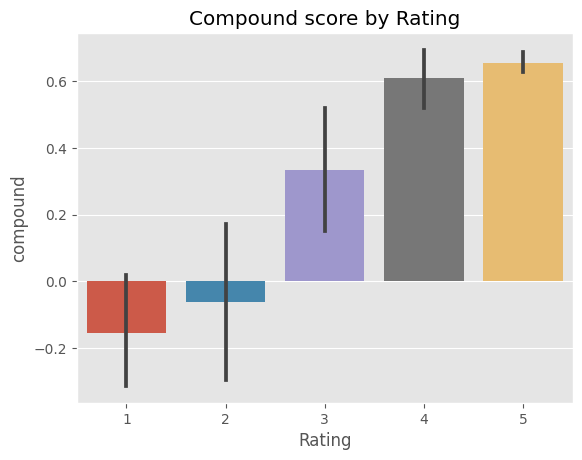

In [823]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compound score by Rating')
plt.show()

It is what we would expect!

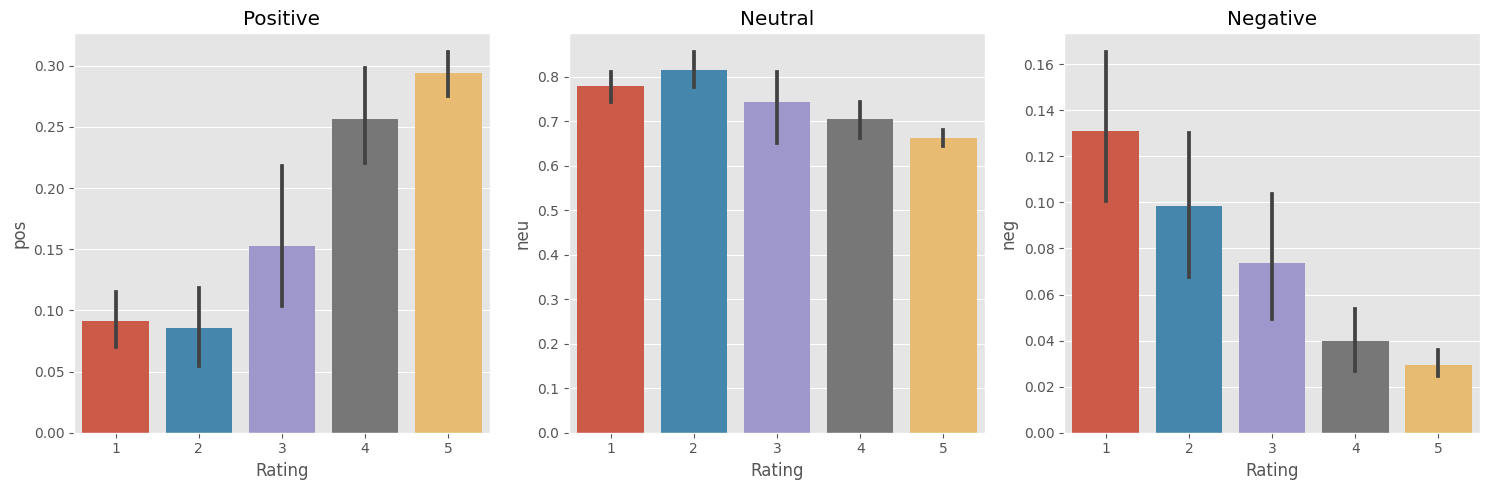

In [824]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = vaders, x='Rating', y='pos', ax = axs[0])
sns.barplot(data = vaders, x='Rating', y='neu', ax = axs[1])
sns.barplot(data = vaders, x='Rating', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

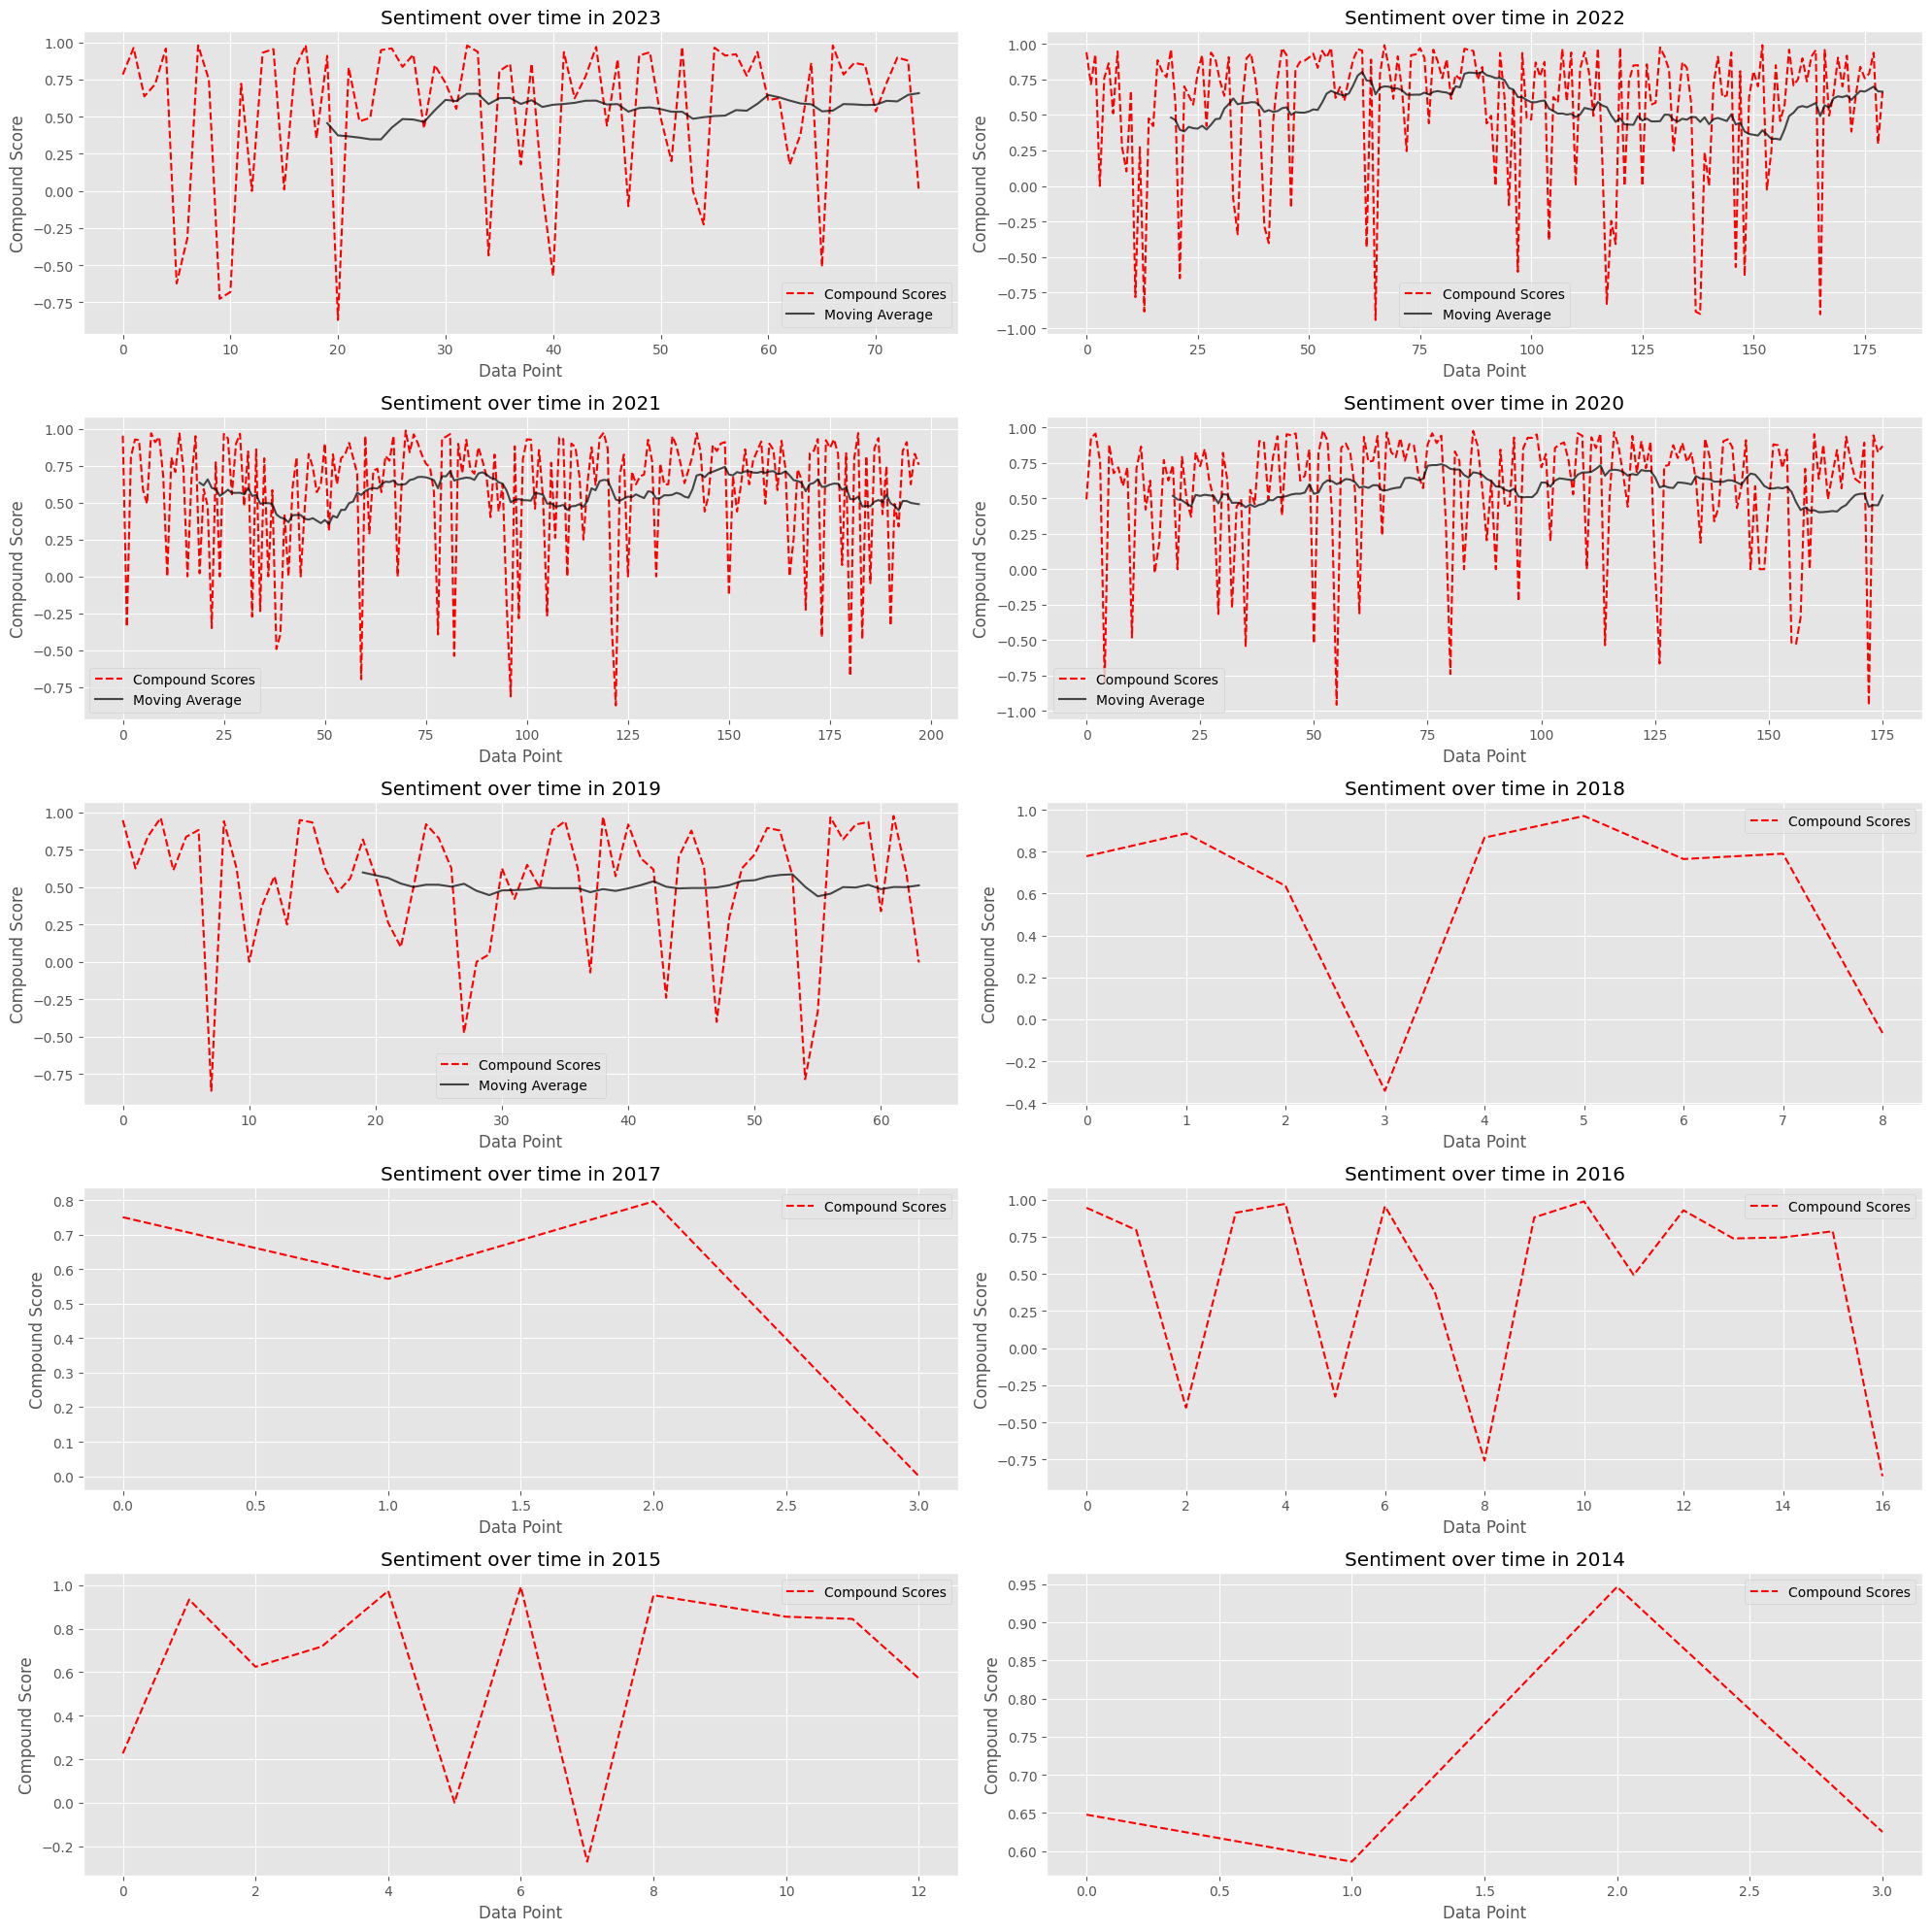

In [886]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))
ax = ax.flatten()

for i, year in enumerate(vaders['Date'].dt.year.unique()):  # Use 'dt.year' to extract the year from the 'Date' column
    # Filter data for the year
    year_data = vaders[vaders['Date'].dt.year == year]['compound'].tolist()
    # Calculate moving average
    if len(year_data) > 60:         # 60 chosen by inspecting how many observations i had for each year
        moving_avg = pd.Series(year_data).rolling(window=20).mean()

        ax[i].plot(year_data, color="red", linestyle='dashed', label='Compound Scores')
        ax[i].plot(moving_avg, color='black', alpha=0.7, label='Moving Average')
        ax[i].set_title(f'Sentiment over time in {year}')
        ax[i].set_xlabel('Data Point')
        ax[i].set_ylabel('Compound Score')
        ax[i].legend()
    
    else:
        ax[i].plot(year_data, color="red", linestyle='dashed', label='Compound Scores')
        ax[i].set_title(f'Sentiment over time in {year}')
        ax[i].set_xlabel('Data Point')
        ax[i].set_ylabel('Compound Score')
        ax[i].legend()

plt.tight_layout()
plt.show()


### RoBERTa

### The Transformers Pipeline

In [825]:
# from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis")

In [826]:
sent_pipeline = ('phrase')